# prologue

### set up notebook and load package

In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.routines as rt
from pandas import Series

# demo datasets that ship with package. all from UCI unless stated otherwise
# ds.adult_data, ds.adult_samp_data, ds.adult_small_samp_data Large dataset ships with manageable sub samples
# ds.bankmark_data, ds.bankmark_samp_data
# ds.car_data
# ds.cardio_data this is the cardiotocography dataset
# ds.credit_data
# ds.german_data
# ds.lending_data, ds.lending_samp_data, ds.lending_small_samp_data, ds.lending_tiny_samp_data from Kaggle. see datasets_from_source file for links
# ds.nursery_data, ds.nursery_samp_data
# ds.rcdv_data, ds.rcdv_samp_data from US government see datasets_from_source file for links

### common config - can be ommitted if defaults are OK

In [2]:
project_dir = 'V:\\whiteboxing' # defaults to a directory "whiteboxing" in the working directory
random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# Build a Random Forest Model to Predict and Explain
First, a wrapper is created for the dataset. Use one that ships with the package, or create your own.
Then split the data into training and (hold out) test set using the convenience functions in the package. These return an object that contain the split data in various representations, such as Pandas DataFrames and encoded, sparse matrices.

In [3]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
mydata = ds.car_data(random_state=random_state, project_dir=project_dir)
meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# build a random forest, tuned for high accuracy

####################### PARAMETER TUNING #######################
################### Only runs when required ####################
### Use the override_tuning = True to force a new tuning run ###
################################################################

best_params, _ = rt.tune_rf(
 X=tt.X_train_enc,
 y=tt.y_train,
 save_path=save_path, # override_tuning=False, # default
 random_state=mydata.random_state)

#### best_params are save to json at the save_path location ####
################################################################

# train a rf model. use onehot encoded training data
# so that cat vars are not converted to ordinal
# this is recommended practice with scikit-learn
# the data_split_container is a convenience wrapper with everything you need

rf = rt.RandomForestClassifier(random_state=random_state, oob_score=True, **best_params)
rf.fit(X=tt.X_train_enc, y=tt.y_train)    

using previous tuning parameters


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

# Evaluate the model and plot a confusion matrix

Confusion matrix, without normalization
[[156   8]
 [  5 349]]


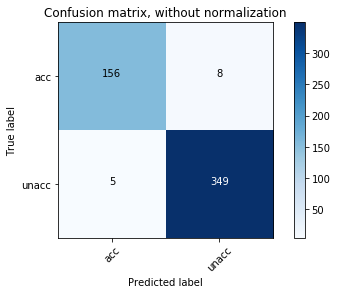

Normalized confusion matrix
[[0.95 0.05]
 [0.01 0.99]]


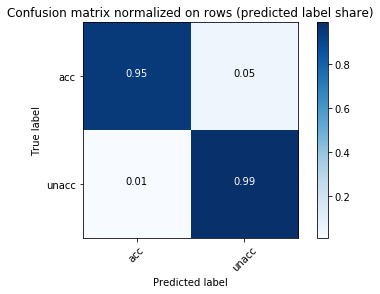

In [4]:
# the outputs of this function are:
# cm - confusion matrix as 2d array
# acc - accuracy of model = correctly classified instance / total number instances
# coka - Cohen's kappa score. Accuracy adjusted for probability of correct by random guess. Useful for multiclass problems
# prfs - precision, recall, f-score, support with the following signatures as a 2d array
# 0 <= p, r, f <= 1. s = number of instances for each true class label (row sums of cm)
test_metrics = rt.evaluate_model(y_true=tt.y_test, y_pred=rf.predict(X_test_enc)
            class_names=meta_data['get_label'](meta_data['class_col']
                                                , [i for i in range(len(meta_data['class_names']))]),
            plot_cm=True, plot_cm_norm=True, # False here will output the metrics and suppress the plots
            save_path=save_path, random_state=random_state)

# Preparing unseen data

Again note:
test set has never been "seen" by random forest during training
test set has been only used to assess model (random forest) accuracy - no additional tuning after this
test set has not be involved in generating the explainer

## optional: memory and computation cost management
#### CHIRPS is time economical but memory intensive to compute for lots of instances at once
option 1: choose a smaller number of instances to explain

In [5]:
# control for async processes - each tree walk can be done in its own core
# and so can each explanation (e.g. rule conditions merge by hill-climbing)
# these will default to false if not passed explicitly to the explainer function
# on a multi-core machine there should be a good speed up for large batches
# when the batch_size advantage exceeds the overhead of setting up multi-processing
# timings will be printed to screen so you can see if it helps
forest_walk_async=True
chirps_explanation_async=False

# the number of instances can be controlled by
# batch_size - how many instances to explain at one time
batch_size = 1
# how many instances to explain in total from a test/unseen set
n_instances = 10000 

# this will normalise the above parameters to the size of the dataset
n_instances, n_batches = rt.batch_instance_ceiling(ds_container=tt, n_instances=n_instances, batch_size=batch_size)

# this gets the next batch out of the data_split_container according to the required number of instances
# all formats can be extracted, depending on the requirement
# unencoded, encoded (sparse matrix is the type returned by scikit), ordinary dense matrix also available
instances, _, instances_enc, instances_enc_matrix, labels = tt.get_next(batch_size, which_split='test') # default

option 2: just run the whole test set

In [6]:
# instances = tt.X_test; instances_enc = tt.X_test_enc; instances_enc_matrix = tt.X_test_enc_matrix; labels = tt.y_test

## Make predictions from the decision forest on the unseen data
Important point, no compromise on model accuracy

In [7]:
# get all the model predictions for the test instance(s) we're looking at
preds_idx = labels.index
preds = rf.predict(X=instances_enc)

# CHIRPS Step 1:
## Extract Tree Prediction Paths
### Fit a forest_walker object to the dataset and decision forest
This is a wrapper will extracts the paths of all the given instances. For CHIRPS, we want a large sample. The whole training set or other representative sample will do.

It can also report interesting statistics (treating the forest as a set of random tree-structured variables).

In [8]:
# wrapper object needs the decision forest itself and the dataset meta data (we have a convenience function for this)
f_walker = strcts.forest_walker(forest = rf, meta_data=meta_data)

Now the work of extracting all the paths for each instance is done

In [9]:
print('Walking forest for ' + str(len(labels)) + ' instances... (please wait)')

# set the timer
forest_walk_start_time = timeit.default_timer()

# do the walk - returns a batch_paths_container (even for just one instance)
# requires the X instances in a matrix (dense, ordinary numpy matrix) - this is available in the data_split_container
bp_container = f_walker.forest_walk(instances = instances_enc_matrix
                        , labels = preds # we're explaining the prediction, not the true label!
                        , forest_walk_async = forest_walk_async)

# stop the timer
forest_walk_end_time = timeit.default_timer()
forest_walk_elapsed_time = forest_walk_end_time - forest_walk_start_time

print('Forest Walk with async = ' + str(forest_walk_async))
print('Forest Walk time elapsed:', "{:0.4f}".format(forest_walk_elapsed_time), 'seconds')

Walking forest for 1 instances... (please wait)
Forest Walk with async = True
Forest Walk time elapsed: 0.7751 seconds


# CHIRPS Steps 2-4: 
## Freqent pattern mining of paths.
## Score and sort mined path segments.
## Merge path segments into one rule.

This is a wrapper object that will execute steps 2-4 on all the instance-paths in the batch_paths_container.

Note that true_divide warnings are OK. It just means that a continuous variable is unbounded in some way i.e. no greater/less than discontinuity is used in the CHIRPS explanation.

Note also, here we are using the training set to create the explainers. We could use a different dataset as long as it is representative of the training set that built the decision forest. Most important that we don't use the dataset that we wish to explain.

In [10]:
# get what the model predicts on the training sample
sample_labels = Series(rf.predict(tt.X_train_enc), index = tt.y_train.index)

# build CHIRPS and a rule for each instance represented in the batch paths container
CHIRPS = strcts.batch_CHIRPS_explainer(bp_container,
                                forest=rf,
                                sample_instances=tt.X_train_enc, # any representative sample can be used
                                # sample_labels=tt.y_train,  # any representative sample can be used
                                sample_labels=sample_labels,
                                meta_data=meta_data)

print('Running CHIRPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
# start a timer
ce_start_time = timeit.default_timer()

CHIRPS.batch_run_CHIRPS(chirps_explanation_async=chirps_explanation_async, alpha_paths=0.4)

ce_end_time = timeit.default_timer()
ce_elapsed_time = ce_end_time - ce_start_time
print('CHIRPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
print('CHIRPS with async = ' + str(chirps_explanation_async))

Running CHIRPS on a batch of 1 instances... (please wait)
CHIRPS time elapsed: 0.4376 seconds
CHIRPS with async = False


# Viewing and Evaluating CHIRPS explanations
Evaluation is done using unseen data to see how well the explanations generalise. The data_split_container object (tt) has a  leave-one-out function that is used during the routine to ensure that the datum we are explaining is excluded from the evaluation.

In [11]:
# iterate over all the test instances to determine the various scores using leave-one-out testing
print('evaluating found explanations')
print()
results_start_time = timeit.default_timer()

rt.evaluate_CHIRPS_explainers(CHIRPS, tt, preds_idx, # the indices here are used to iterate through the leave-one-out function
                              forest=rf,
                              print_to_screen=True,
                              eval_alt_labelings=True,
                              eval_rule_complements=True,
                              save_results_path=meta_data['get_save_path'](),
                              save_results_file='results' + '_rnst_' + str(mydata.random_state),
                              save_CHIRPS=True)

results_end_time = timeit.default_timer()
results_elapsed_time = results_end_time - results_start_time
print('CHIRPS batch results eval time elapsed:', "{:0.4f}".format(results_elapsed_time), 'seconds')
# this completes the CHIRPS runs

evaluating found explanations

INSTANCE RESULTS
instance id: 1633 with true class label: 0 (acc)

Model Results for Instance
target (predicted) class: 0 (acc)
target class prior (training data): 0.29256198347107437
forest vote share (unseen instance): 0.748
forest vote margin (unseen instance): 0.496
rule: maint_vhigh False AND persons_2 False AND safety_low False AND lug_boot_small False AND buying_vhigh False
rule cardinality: 5

Estimated Results - Rule Training Sample. Algorith: greedy_stab
rule coverage (training data): 0.16198347107438016
rule xcoverage (training data): 0.16184971098265896
rule precision (training data): 0.9642857142857143
rule stability (training data): 0.9593908629441624
rule recall (training data): 0.5338983050847458
rule f1 score (training data): 0.6872727272727274
rule lift (training data): 20.347784997776355
prior (training data): [0.29256198 0.70743802]
prior counts (training data): [354 856]
rule posterior (training data): [0.96428571 0.03571429]
rule pos

In [15]:
CHIRPS.CHIRPS_explainers[0].posterior

array([[0.29256198, 0.70743802],
       [0.77525253, 0.22474747],
       [0.87878788, 0.12121212],
       [0.96428571, 0.03571429]])

In [16]:
preds

array([0], dtype=int64)

In [17]:
rf.predict(tt.X_train_enc)

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

Running defragTrees

[Seed 123] TrainingError = 0.29, K = 2
[Seed 124] TrainingError = 0.29, K = 4
Optimal Model >> Seed 124, TrainingError = 0.29, K = 4
Fit defragTrees time elapsed: 54.0637 seconds



<< defragTrees >>
----- Evaluated Results -----
Test Error = 0.291736
Test Coverage = 1.000000
Overlap = 0.005785

----- Found Rules -----
[Rule  1]
y = 0 when
	 buying_low < 0.500000
	 buying_med < 0.500000
	 maint_low >= 0.500000
	 doors_4 >= 0.500000
	 persons_more >= 0.500000
	 lug_boot_med < 0.500000
	 safety_med < 0.500000

[Rule  2]
y = 1 when
	 doors_3 < 0.500000
	 doors_4 < 0.500000
	 doors_5more < 0.500000

[Rule  3]
y = 1 when
	 doors_2 < 0.500000
	 safety_med >= 0.500000

[Rule  4]
y = 1 when
	 doors_2 < 0.500000
	 safety_med < 0.500000

[Otherwise]
y = 1



[[('buying_low', True, 0.5), ('buying_med', True, 0.5), ('maint_low', False, 0.5), ('doors_4', False, 0.5), ('persons_more', False, 0.5), ('lug_boot_med', True, 0.5), ('safety_med', True, 0.5)], [('doors_3', True, 0.5), ('doors_4', True, 0.5), ('doors_5more', True, 0.5)], [('doors_2', True, 0.5), ('safety_med', False, 0.5)], [('doors_2', True, 0.5), ('safety_med', True, 0.5)]]
